<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: 3.0 Modelling - CT Scan Image Stroke Detector
> Authors: Michael King Sutanto, Eugene Matthew Cheong, Pius Yee

##### In this notebook, we will train a Keras CNN model to predict stroke risk using CT scan images.

---
## Table of Contents ##

### Notebook 3.0 Modelling - CT Scan Image Stroke Detector ###

#### 1. Importing libraries

#### 2. Preparing data

[2.1 Setup Data Directory](#2.1-setup-data-directory)

[2.2 Data augmentation and preprocessing](#2.2-data-augmentation-and-preprocessing)

#### 3. Modelling

[3.1 Model Architecture](#3.1-model-architecture)

[3.2 Model Training](#3.2-model-training)

[3.3 Model Evaluation](#3.3-model-evaluation)

[3.3.1 Review `Loss` and `Recall` over training Epochs](#3.3.1-Review-Loss-and-Recall-over-training-Epochs)

[3.3.2 Model scores](#3.3.2-model-scores)

[3.3.3 Confusion map](#3.3.3-confusion-map)

[3.4 Evaluate the prediction with random test data](#3.4-evaluate-the-prediction-with-random-test-data)

#### 4. Model export

[4.0 Model export](#4.-model-export)

#### 5.0 Summary - CT Scan image model

[5.0 Summary - CT Scan image model](#5.0-Summary---CT-scan-image-Model)

#### For overall Project 4

[Limitation of the models](#limitation-of-the-models)

[Recommendation](#recommendation)

[Conclusion](#conclusion)

---

## 1. Import Libraries

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from gradcam import GradCAM

## 2. Preparing Data

### 2.1 Setup Data Directory

##### We have CT scan image datasets for Train, Test and Validation. In each datasets, there are 2 separate directories for `stroke` and `normal` images.

In [2]:
data_dir = '../datasets/brain_datasets/' # main directory
train_dir = os.path.join(data_dir, 'Train') # for train data
test_dir = os.path.join(data_dir, 'Test') # for test data
validation_dir = os.path.join(data_dir, 'Validation') # for validation data

### 2.2 Data augmentation and preprocessing

##### Before fitting into model, we will import and process the CT scan images. 

##### We also use augmentation on the images to artificially expands the training data with variations to prevent overfitting and improve model performance on unseen images.

In [3]:
# set the image dimensions
img_width, img_height = 256, 256


# Updated Data augmentation and preprocessing with additional rotation +/- 10 degree and zoom +/- 10%
train_datagen = ImageDataGenerator(   # for train data
    rescale=1.0/255.0,
    rotation_range=10, # Random rotations
    zoom_range=0.1  # Random zooming
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0) # for test data (without augmentation)


# Setting up generators
train_data = train_datagen.flow_from_directory( # flow_from_directory automatically infers labels (stroke or not) based on subfolder names (stroke and normal).
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

validation_data = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

Found 1843 images belonging to 2 classes.


Found 235 images belonging to 2 classes.


##### We have 41% of stroke images and 59% of non-stroke images in the training data.

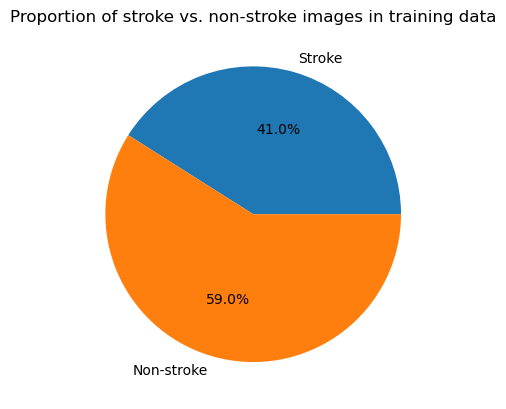

In [4]:
# define the data
sum_stroke = len([i for i in train_data.classes if i == 1]) # number of images for stroke
sum_nonstroke = len([i for i in train_data.classes if i == 0]) #number of images for non-stroke

# Create the pie chart
plt.pie([sum_stroke,sum_nonstroke], labels=['Stroke', 'Non-stroke'], autopct="%1.1f%%")  # autopct displays percentages

# Add a title
plt.title('Proportion of stroke vs. non-stroke images in training data')

# Display the pie chart
plt.show()

## 3. Modeling

### 3.1 Model Architecture

Model went through an iterative process, started with lesser layers.  
We use many layers to extract low level features in the initial layers and to capture high level abstract features in the end layers.  
The pooling laters help us reduce dimensionality and computational load while preserving important features.

In [5]:
# use sequential as the model
model = Sequential()

# build a sequential CNN model with convolutional layers for feature extraction and pooling layers for downsampling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

#  fully connected layers for final classification
model.add(Flatten()) # Flatten the data for fully connected layers
model.add(Dense(64, activation='relu')) # Fully connected layer
model.add(Dense(1, activation='sigmoid')) # Output layer with sigmoid activation for binary classification (stroke or not)

model.summary()

/Users/piusyee/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-12 11:17:09.981419: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-12 11:17:09.981453: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-12 11:17:09.981469: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-12 11:17:09.981758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-12 11:17:09.981776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,466,177 (28.48 MB)

 Trainable params: 7,466,177 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Model Training

Since this is a medical application, we will prioritize sensitivity (recall) as our metric to minimize false negatives."

In [6]:
# Compile the model (specifies loss function, optimizer, and metrics)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['recall'])

# fit the model on train data
history = model.fit(train_data, epochs=25, validation_data=validation_data)

Epoch 1/25


2024-04-12 11:17:11.374617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/piusyee/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 318ms/step - loss: 0.8120 - recall: 0.2263 - val_loss: 0.5784 - val_recall: 0.3205
Epoch 2/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - loss: 0.6192 - recall: 0.3251 - val_loss: 0.5107 - val_recall: 0.5897
Epoch 3/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - loss: 0.5696 - recall: 0.4610 - val_loss: 0.5198 - val_recall: 0.7308
Epoch 4/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - loss: 0.5426 - recall: 0.5932 - val_loss: 0.3832 - val_recall: 0.6154
Epoch 5/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - loss: 0.4822 - recall: 0.6438 - val_loss: 0.3989 - val_recall: 0.7692
Epoch 6/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 382ms/step - loss: 0.4473 - recall: 0.6981 - val_loss: 0.3358 - val_recall: 0.7436
Epoch 7/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - loss: 0.3950 - recall: 0.7333 - val_loss: 0.3393 - val_recall: 0.8462
Epoch 8/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 408ms/step - loss: 0.3574 - recall: 0.8069 - val_loss: 0.2983 - val_recall: 0.8205
Epoch 9/25


In [7]:
# evaluate the model with test data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

loss, recall = model.evaluate(test_data)
print('Test Loss:', loss)
print('Test Recall:', recall)

Found 437 images belonging to 2 classes.


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.1279 - recall: 0.3435
Test Loss: 0.18708448112010956
Test Recall: 0.9076923131942749


### 3.3 Model Evaluation

#### 3.3.1 Review `Loss` and `Recall` over training Epochs

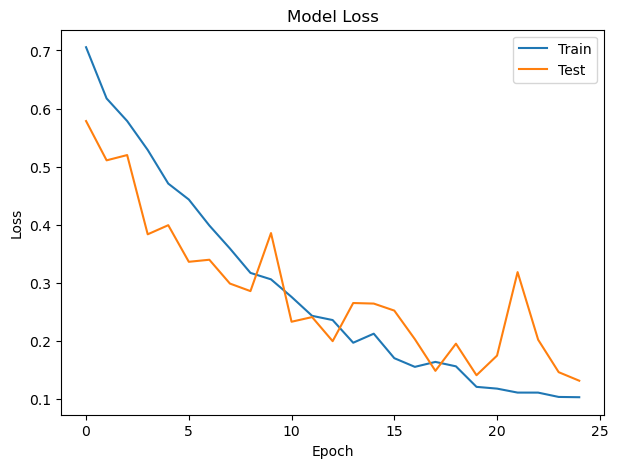

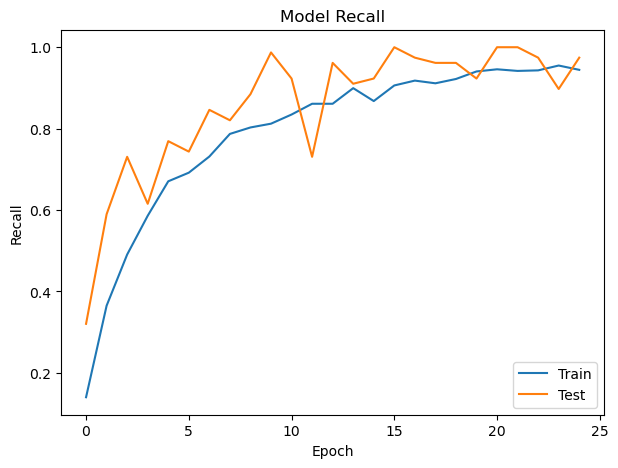

In [8]:
# Plot loss versus epoch
fig = plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
fig.savefig('../images/Loss.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

# Plot recall versus epoch
fig = plt.figure(figsize=(7, 5))
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Test'], loc='lower right')
fig.savefig('../images/Recall.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

##### Based on the plots above, the model's performance has significantly improved over epochs.

#### 3.3.2 Model scores

##### We evaluate the model scores based on the test data

In [9]:
# Evaluate
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

y_pred = model.predict(test_data)
y_pred = np.round(y_pred).flatten()
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred)
accuracy=accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('\nClassification Report:\n')
print(classification_report(y_true, y_pred))
print('\n------------------------------------------------------\n')

print('Accuracy:',accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

print('\n------------------------------------------------------\n\n')


Found 437 images belonging to 2 classes.
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       307
           1       0.89      0.91      0.90       130

    accuracy                           0.94       437
   macro avg       0.92      0.93      0.93       437
weighted avg       0.94      0.94      0.94       437


------------------------------------------------------

Accuracy: 0.9382151029748284
Precision: 0.8872180451127819
Recall: 0.9076923076923077
F1 Score: 0.8973384030418251

------------------------------------------------------




#### 3.3.3 Confusion map

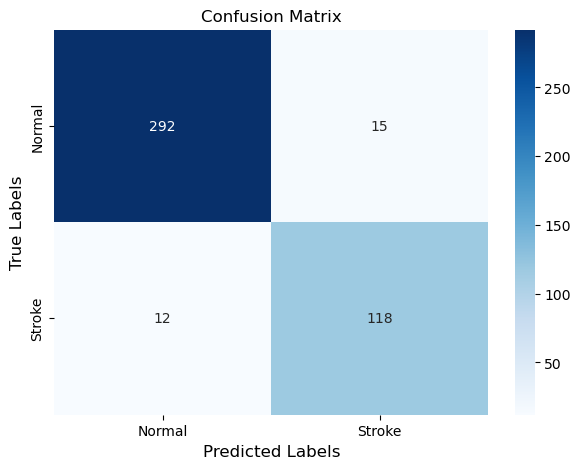

In [10]:
# Plot confusion matrix
label_names = ['Normal', 'Stroke']  # Replace with your class labels
beingsaved = plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xticks(np.arange(len(label_names)) + 0.5, label_names)
plt.yticks(np.arange(len(label_names)) + 0.5, label_names)
plt.xlabel('Predicted Labels',fontsize=12)
plt.ylabel('True Labels',fontsize=12)
plt.title('Confusion Matrix')
beingsaved.savefig('Stroke_Confusion_Matrix.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

##### Based on the confusion map, the performance is very good. We have high true positive and true negative.

#### 3.4 Evaluate the prediction with random test data

##### (a) Test with a CT scan with `stroke`:

In [11]:
target_class_index = 1
img_path = '../datasets/brain_datasets/Test/Stroke/77 (32).jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (img_width, img_height))
img = np.expand_dims(img, axis=0) / 255.0

predicted_class = model.predict(img)

print(f'Patient has {format(predicted_class[0][0]*100, ".2f")}% chance of getting stroke.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Patient has 98.67% chance of getting stroke.


The model predicted correctly as high chance of `stroke`.

##### (b) Test with a CT scan with `normal`:

In [12]:
target_class_index = 1
img_path = '../datasets/brain_datasets/Test/Normal/61 (17).jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (img_width, img_height))
img = np.expand_dims(img, axis=0) / 255.0

predicted_class = model.predict(img)

print(f'Patient has {format(predicted_class[0][0]*100, ".2f")}% chance of getting stroke.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Patient has 0.59% chance of getting stroke.


The model predicted correctly as low chance of `stroke`.

## 4. Model export

##### Exporting the model to use it in streamlit

In [13]:
# Export as recommended Tensorflow 2 format.
model.save('../models/ctscan_model.keras')

# Export as Keras H5 format
model.save('../models/ctscan_model.h5')

## 5. Summary - CT scan image model

##### The brain model used Keras CNN model which have a good performance in preducting stroke and non-stroke. As such we will use it in our CT scan image classification model.

---

# *For overall Project 4:-*

## Limitation of the models

- `Limited Training Data` : Due to limited data, the model might be overly specific to the training data (overfitting) or lack the complexity to capture the data's patterns (underfitting), hindering its ability to generalize well to unseen examples.

- `Black box models` : Complex models like neural networks can be highly effective but often lack clear explanations for their decisions. This can make them unsuitable for domains where understanding the reasoning behind a prediction is crucial.


## Recommendation

We need to find more training data to improve our models. Here are some ways to address dataset limitations in specific areas:

- `Obesity`: For the obesity dataset, we could find more data on waist circumference and fat mass. This would make the model even more accurate.

- `Stroke`: The current stroke dataset has a minority of stroke-positive examples.  Finding a bigger dataset with a more balanced distribution could improve the model's performance.

- `CT Image scan`: We can improve the accuracy of our model by finding more CT image scans for training


## Conclusion

The models successfully address the problem statement by making it easier to identify patients at risk of stroke. They provide a solution to the need for a streamlined system that uses detailed patient information, including proper classification of obesity status, to improve stroke risk assessment during triage. This enables physicians to promptly refer at-risk patients for further evaluation, potentially reducing the likelihood of stroke occurrence.